# <center>Application of Ant Colony Optimization, Artificial Bee Colony and Genetic Algorithm in FSP problem</center>

This notebook presents a practical approach to solving the flowshop problem by implementing the Ant Colony Optimization algorithm. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, such metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions

You can visit the website to test the implemented Population based Metaheuristics and gain a comparative insight :  https://flow-shop-problem.streamlit.app


# Table of Contents

1. [Data utils](#Data-utils)
2. [Genetic Algorithm for FSP](#Genetic-Algorithm-for-FSP)
3. [Tests AG](#Tests-AG)
4. [Ant colony for FSP](#Ant-colony-for-FSP)
5. [Tests ACO](#Tests-ACO)
6. [Artificial Bee Colony for FSP](#Artificial-Bee-Colony-for-FSP)
7. [Tests ABC](#Tests-ABC)
8. [Comparison Figure](#Comparison-Figure)


# Data utils

In [1]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.benchmarks import benchmarks, upper_bound
from utils.heuristics import *
from utils.utils import read_flow_shop_data

## Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [2]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

## Gantt graph generator

In [3]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

# Genetic Algorithm for FSP

### L'opérateur de selection
- Sélectionner certaines solutions pour former la population intermédiaire afin de lui appliquer les opérateurs de croisement et de mutation.

In [4]:
def selection_AG(population, processing_times, n_selected, strategie):
    """
    Sélectionne une sous-population en fonction de la stratégie spécifiée.

    Args:
        population (list): La population actuelle de chromosomes (solutions).
        processing_times (array): Matrice des temps de traitement par machine et par job.
        n_selected (int): Nombre d'individus à sélectionner.
        strategie (str): Stratégie de sélection ('roulette', 'Elitism', 'rank', 'tournament').

    Returns:
        list: La sous-population sélectionnée selon la stratégie.
    """

    # Sélection par roulette:
    if strategie == "roulette":
        # Calcul de la fitness pour chaque individu dans la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Somme des valeurs de fitness pour normalisation
        fitness_sum = sum(fitness)
        # Calcul des probabilités de sélection proportionnelles à la fitness
        selection_probs = [fitness[i] / fitness_sum for i in range(len(population))]
        # Cumul des probabilités pour faciliter la sélection aléatoire
        cum_probs = [sum(selection_probs[:i+1]) for i in range(len(population))]
        selected = []

        # Sélection de n individus en fonction des probabilités cumulées
        for i in range(n_selected):
            while True:
                rand = random.random()
                for j, cum_prob in enumerate(cum_probs):
                    if rand < cum_prob:
                        break
                # Assure que chaque individu sélectionné est unique
                if population[j] not in selected:
                    selected.append(population[j])
                    break

    # Sélection par élitisme:
    elif strategie == "Elitism":
        # Évaluation de la fitness pour toute la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Tri de la population basé sur la fitness
        sorted_population = [x for x, _ in sorted(zip(population, fitness), key=lambda pair: pair[1])]
        # Sélection des meilleurs individus
        selected = sorted_population[:n_selected]

    # Sélection par classement:
    elif strategie == "rank":
        # Évaluation de la fitness pour toute la population
        fitness = [calculate_makespan(processing_times, sequence) for sequence in population]
        # Tri de la population par fitness
        sorted_population = sorted(population, key=lambda x: fitness[population.index(x)])
        # Calcul des poids pour la sélection aléatoire
        fitness_sum = sum(i + 1 for i in range(len(sorted_population)))
        selection_probs = [(len(sorted_population) - i) / fitness_sum for i in range(len(sorted_population))]
        selected = []

        # Sélection de n individus en fonction des poids
        for i in range(n_selected):
            selected_index = random.choices(range(len(sorted_population)), weights=selection_probs)[0]
            selected.append(sorted_population[selected_index])
            # Suppression pour éviter duplication dans les choix
            sorted_population.pop(selected_index)
            selection_probs.pop(selected_index)

    # Sélection par tournoi:
    elif strategie == "tournament":
        k = 2  # Taille du tournoi
        selected = []

        # Répéter jusqu'à ce que n individus soient sélectionnés
        for i in range(n_selected):
            while True:
                # Choix aléatoire de k individus
                tournament = random.sample(population, k)
                # Filtrer les individus déjà sélectionnés
                tournament = [seq for seq in tournament if seq not in selected]
                if tournament:
                    break
            # Évaluation de la fitness des individus du tournoi
            fitness = [calculate_makespan(processing_times, sequence) for sequence in tournament]
            # Sélection de l'individu avec la meilleure fitness
            selected.append(tournament[fitness.index(min(fitness))])

    return selected


### L'opérateur de croisement ( Crossover )
- Son principe est de prendre deux individus aléatoirement et de couper chacun d’eux en un ou plusieurs points, ensuite, inter changer les gènes situés entres les points considérés.

In [5]:
def remove_duplicates_AG(enfant, other_enfant, points):
    # Calcul de la taille de la liste des jobs, moins un pour obtenir l'indice maximum utilisable.
    jobs = len(enfant) - 1

    # Détermine si les points de crossover fournis sont multiples (typiquement pour un crossover à deux points).
    check_points = len(points) > 1

    # Boucle continue jusqu'à ce que tous les duplicats soient résolus.
    while True:
        # Crée un ensemble de jobs qui apparaissent plus d'une fois dans l'offspring.
        duplicates = set([job for job in enfant if enfant.count(job) > 1])

        # Si aucun duplicat n'est trouvé, sortir de la boucle.
        if not duplicates:
            break

        # Traiter chaque job dupliqué trouvé.
        for job in duplicates:
            # Trouve toutes les positions de ce job dans l'offspring.
            pos = [i for i, x in enumerate(enfant) if x == job]

            # Détermine quelle position du job dupliqué doit être corrigée.
            # Si des points de crossover sont spécifiés et que la première occurrence du job dupliqué est hors de ces points,
            # ou si aucun point n'est spécifié et que la première occurrence est avant le premier point,
            # alors 'dup' est la première position, sinon c'est la seconde.
            if (check_points and ((pos[0] < points[0]) or (pos[0] >= points[1])) ) or ( (pos[0] < points[0]) and not check_points):
                dup = pos[0]
                index = pos[1]
            else:
                dup = pos[1]
                index = pos[0]

            # Remplace le job dupliqué à la position 'dup' par un job de 'other_offspring' à la position 'index'.
            # Cette substitution est faite pour corriger la duplication tout en essayant de préserver la structure génétique du parent non-dupliqué.
            enfant[dup] = other_enfant[index]

    # Retourne l'offspring corrigé.
    return enfant


In [6]:
def crossover_AG(parent1, parent2, points):
    # Calcul de l'indice maximal utilisable pour le point de crossover, basé sur la longueur du parent.
    jobs = len(parent1) - 1

    # Si le mode de crossover est à un seul point ("ONE").
    if points == 'ONE':
        # Choix aléatoire d'un point de crossover dans la plage valide.
        point = random.randint(0, jobs)
        # Création de deux enfants en combinant les segments des deux parents autour du point de crossover.
        enfant1 = parent1[:point] + parent2[point:]
        enfant2 = parent2[:point] + parent1[point:]
        # Mise à jour des points pour la suppression des doublons.
        points = [point]

    else:  # Si le mode de crossover est à deux points.
        # Choix aléatoire de deux points de crossover.
        point_1 = random.randint(0, jobs)
        point_2 = random.randint(0, jobs)
        # Assurer que point_1 est inférieur à point_2.
        if point_1 > point_2:
            point_1, point_2 = point_2, point_1
        # Création des enfants en échangeant les segments entre les deux points choisis.
        enfant1 = parent1[:point_1] + parent2[point_1:point_2] + parent1[point_2:]
        enfant2 = parent2[:point_1] + parent1[point_1:point_2] + parent2[point_2:]
        # Mise à jour des points pour la suppression des doublons.
        points = [point_1, point_2]

    # Appel de la fonction pour retirer les doublons, en passant les enfants créés et les points de crossover.
    enfant1 = remove_duplicates_AG(enfant1, enfant2, points)
    enfant2 = remove_duplicates_AG(enfant2, enfant1, points)

    # Retourne les deux enfants après élimination des duplications.
    return enfant1, enfant2


### L'opérateur de mutation 
- Il consiste à choisir un ou deux bits aléatoirement, puis les inverser. L'opérateur de mutation s'applique avec une certaine probabilité Pm,
- Aide à maintenir et à introduire de la diversité génétique dans la population, ce qui peut empêcher l'algorithme de converger prématurément vers des optima locaux. 

In [7]:
def mutation_AG(sequence, mutation_rate):
    # Calcul de la longueur de la séquence, correspondant au nombre de jobs ou tâches
    num_jobs = len(sequence)
    
    # Parcours de chaque élément de la séquence pour potentiellement le muter
    for i in range(num_jobs):
        # Génération d'un nombre aléatoire entre 0 et 1
        r = random.random()
        
        # Vérification si ce nombre est inférieur au taux de mutation
        if r < mutation_rate:
            # Création d'une liste des indices de tous les jobs sauf celui à l'index i pour éviter de muter un job avec lui-même
            available_jobs = [j for j in range(num_jobs) if j != sequence[i]]
            
            # Sélection aléatoire d'un nouvel index de job parmi les disponibles
            newjob = random.sample(available_jobs, 1)[0]
            
            # Echange des positions dans la séquence pour introduire la mutation
            sequence[sequence.index(newjob)], sequence[i] = sequence[i], newjob
    
    # Retour de la séquence mutée après potentiellement plusieurs mutations
    return sequence


### Algorithme AG


1. **Début**
2. Génération d’une population initiale
3. **Tant que** critère d’arrêt non atteint **faire**
    1. Sélection
    2. Croisement
    3. Mutation
    4. Mise à jour de la population ( L'opérateur de remplacement )
4. **Fin Tant que**
5. **Fin**

**Critère d'arrêt :**
   - un nombre d’itérations prédéfini est atteint.
   - ou bien lorsque la population cesse d'évoluer ou évolue très lentement.

In [8]:
def genetic_algorithm(processing_times, init_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations):

    # Init population generation
    population = init_pop
    best_seq = selection_AG(population, processing_times, 1, "Elitism")[0]
    best_cost = calculate_makespan(processing_times, best_seq)
    for i in range(num_iterations):
        # Selection
        s = int(select_pop_size * pop_size) # number of selected individus to be parents (%)
        parents = selection_AG(population, processing_times, s, selection_method)
        # Crossover
        new_generation = []
        for _ in range(0, pop_size, 2):
            parent1 = random.choice(parents)
            parent2 = random.choice([p for p in parents if p != parent1])
            child1, child2 = crossover_AG(parent1, parent2, crossover)
            new_generation.append(child1)
            new_generation.append(child2)

        new_generation = new_generation[:pop_size]
        # Mutation
        for i in range(pop_size):
            if random.uniform(0, 1) < mutation_probability:
                new_generation[i] = mutation_AG(new_generation[i], mutation_probability)
        # Replacement
        population = new_generation

        # checking for best seq in current population
        best_seq_pop = selection_AG(population, processing_times, 1, "Elitism")[0]
        best_cost_pop = calculate_makespan(processing_times, best_seq_pop)
        if best_cost_pop < best_cost:
            best_seq = best_seq_pop.copy()
            best_cost = best_cost_pop

    return best_seq

### Finding optimal params avec IRICE pour AG

In [9]:
def optimal_params_AG(processing_times,selection_method,crossover):
    # Définir l'espace des paramètres
    space = [
        Integer(25, 50, name='pop_size'),
        Real(0.5, 0.7, name='select_pop_size'),
        Real(0.05, 0.1, name='mutation_probability'),
        Integer(50, 200, name='num_iterations'),
    
    ]

    # Dictionnaire pour stocker les populations initiales par paramètres
    initial_pops = {}
    # Fonction objectif à minimiser

    @use_named_args(space)
    def objective(**params):
        pop_size = params['pop_size']
        select_pop_size = params['select_pop_size']
        mutation_probability = params['mutation_probability']
        num_iterations = params['num_iterations']
    
       # La population initiale 

        initial_pop =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

        # Enregistrement de la population initiale avec la clé des paramètres actuels
        params_key = (pop_size, select_pop_size, mutation_probability, num_iterations)
        initial_pops[params_key] = initial_pop

        # print("Initial Poplation : ", initial_pop)

        result = genetic_algorithm(processing_times, initial_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

        
        return calculate_makespan(processing_times,result)


    # Lancer l'optimisation
    result  = gp_minimize(objective, space, n_calls=20, random_state=0)
    # Affichage des meilleurs paramètres trouvés

    check = int(result.x[1] * result.x[0])
    try:
        if check < 2:
            raise ValueError("there should be at least two selected parents : please increase the % of selection")
        comb = math.comb(check, 2) * 2
        if comb < result.x[0]:
            raise ValueError("The maximum size of population with the choosed parameters is "+str(comb)+" sequences : please increase the % of selection or decrease the size of population")        
    except ValueError as e:
        print(e)
    
    # Récupérer la population initiale qui a donné les meilleurs paramètres
    best_params = result.x
    best_params_key = tuple(best_params)
    initial_pop = initial_pops[best_params_key]

    # Affichage des meilleurs paramètres trouvés
    print("Meilleurs paramètres: pop_size={}, select_pop_size={}, mutation_probability={}, num_iterations={}".format(
        result.x[0], result.x[1], result.x[2], result.x[3]))
    return initial_pop ,result.x[0], result.x[1], result.x[2], result.x[3]

## Tests AG

###  Taillard, 20 jobs & 5 machines

In [10]:
nb_jobs = 20
nb_machines = 5
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux

In [11]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100
GA_SPO = []

In [12]:
processing_times = benchmarks[0][2].T # la première instance 

initial_pop =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial Poplation : ", initial_pop)

start_time = time.time()
best_solution  = genetic_algorithm(processing_times, initial_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

Elapsed_time = time.time() - start_time
best_cost =  calculate_makespan(processing_times, best_solution)
print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 1278") 
print("Elapsed time:", Elapsed_time, "seconds \n")
RDP = best_cost - 1278
GA_SPO.append(["20 J & 5 M",RDP])

Initial Poplation :  [[11, 5, 0, 14, 2, 8, 13, 19, 4, 16, 18, 12, 1, 15, 7, 6, 10, 17, 9, 3], [5, 6, 9, 19, 13, 3, 11, 8, 10, 18, 7, 15, 16, 17, 1, 12, 2, 14, 0, 4], [17, 11, 18, 7, 16, 5, 2, 4, 10, 13, 0, 6, 15, 1, 3, 9, 19, 14, 12, 8], [7, 15, 17, 13, 4, 12, 16, 10, 14, 9, 6, 19, 1, 11, 3, 5, 0, 8, 18, 2], [14, 5, 3, 13, 15, 0, 8, 10, 12, 19, 11, 1, 2, 18, 4, 7, 16, 9, 17, 6], [12, 9, 8, 7, 13, 17, 5, 14, 0, 10, 18, 15, 2, 16, 11, 1, 3, 19, 4, 6], [7, 1, 9, 19, 17, 11, 15, 8, 12, 3, 18, 2, 5, 4, 0, 13, 6, 10, 16, 14], [4, 19, 12, 14, 11, 18, 16, 0, 1, 17, 7, 15, 13, 10, 2, 8, 9, 5, 6, 3], [2, 0, 6, 14, 7, 1, 18, 4, 12, 13, 8, 10, 11, 9, 19, 3, 15, 17, 16, 5], [8, 0, 11, 5, 7, 18, 13, 17, 2, 10, 6, 4, 12, 9, 3, 14, 15, 1, 16, 19], [14, 2, 5, 18, 6, 8, 9, 13, 0, 12, 4, 3, 7, 16, 11, 15, 10, 17, 1, 19], [10, 11, 13, 16, 8, 7, 14, 2, 5, 15, 0, 18, 4, 12, 9, 3, 1, 17, 19, 6], [16, 7, 1, 12, 10, 13, 15, 8, 19, 9, 5, 17, 14, 2, 18, 0, 3, 6, 11, 4], [8, 14, 17, 0, 19, 9, 18, 16, 1, 3, 11, 6,

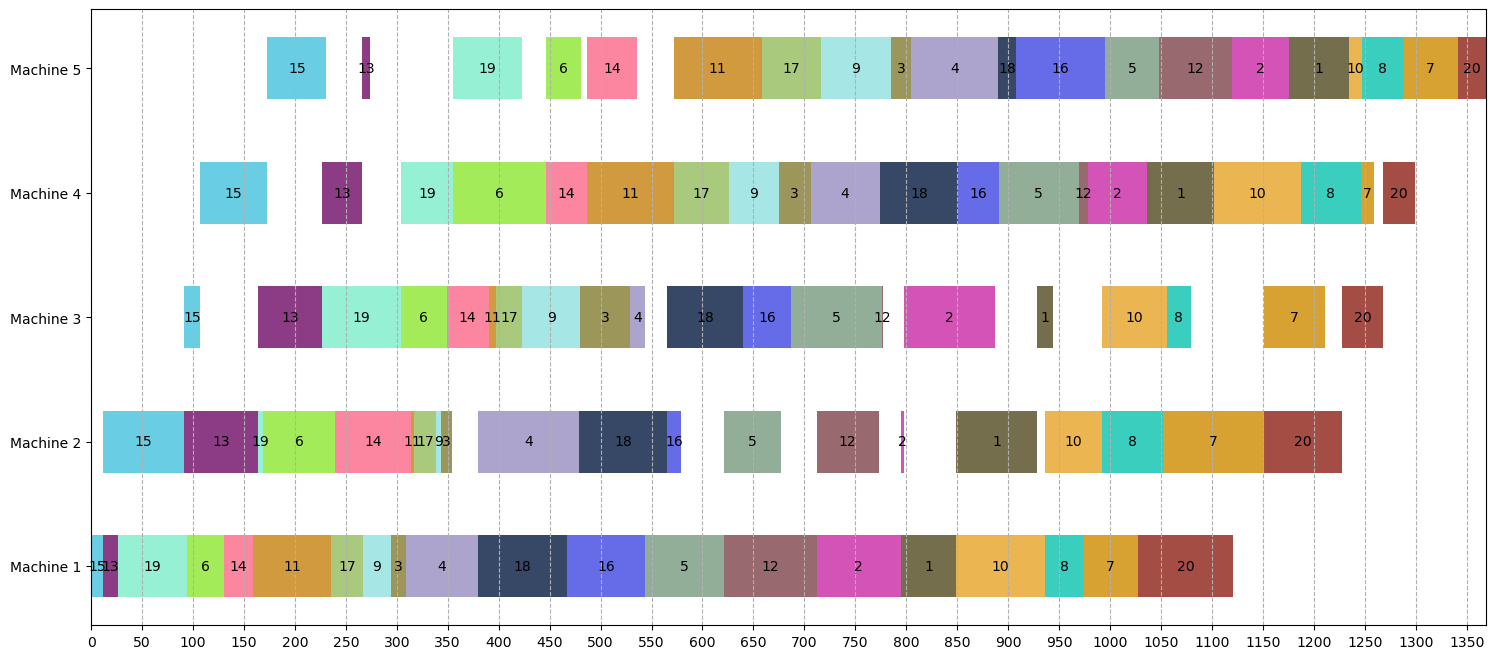

In [13]:
generate_gantt_chart(processing_times,best_solution)

#### Avec les Meilleurs Hyper Parameters

In [14]:
GA_APO = []

In [15]:
initial_pop , best_pop_size, best_select_pop_size , best_mutation_probability, best_num_iterations = optimal_params_AG(processing_times,"roulette","TWO")

Meilleurs paramètres: pop_size=40, select_pop_size=0.5790916332068009, mutation_probability=0.06493013195937519, num_iterations=162


In [16]:
print("Initial Poplation : ", initial_pop)

start_time = time.time()

best_solution = genetic_algorithm(processing_times, initial_pop, best_pop_size, best_select_pop_size, selection_method, crossover, best_mutation_probability, best_num_iterations)

Elapsed_time = time.time() - start_time

best_cost = calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution " ,best_cost) 
print("Real Makespann is 1278") 
print("Elapsed time:", Elapsed_time, "seconds \n")

RDP = best_cost - 1278
GA_APO.append(["20J & 5M",RDP])

Initial Poplation :  [[15, 14, 9, 16, 10, 0, 3, 11, 1, 12, 8, 6, 19, 13, 2, 7, 17, 18, 4, 5], [7, 19, 11, 15, 4, 16, 13, 5, 9, 8, 18, 14, 17, 0, 2, 10, 6, 3, 1, 12], [15, 18, 16, 11, 1, 4, 14, 8, 7, 9, 2, 6, 12, 3, 10, 0, 13, 19, 5, 17], [18, 2, 13, 19, 12, 9, 1, 3, 8, 16, 0, 15, 17, 6, 11, 7, 10, 4, 14, 5], [15, 2, 14, 11, 1, 13, 8, 16, 5, 7, 10, 12, 0, 19, 4, 17, 3, 18, 6, 9], [13, 1, 5, 7, 3, 4, 19, 9, 17, 15, 10, 18, 11, 12, 6, 0, 16, 8, 14, 2], [12, 18, 4, 3, 13, 6, 16, 17, 1, 7, 14, 5, 15, 8, 10, 11, 19, 0, 9, 2], [4, 17, 19, 13, 15, 6, 9, 7, 8, 14, 2, 11, 0, 3, 1, 12, 16, 10, 5, 18], [12, 4, 15, 0, 14, 3, 7, 6, 8, 17, 16, 5, 19, 2, 18, 11, 13, 10, 9, 1], [7, 5, 16, 17, 12, 9, 2, 19, 10, 4, 18, 15, 8, 0, 11, 13, 6, 14, 3, 1], [4, 8, 7, 18, 19, 13, 3, 17, 9, 5, 1, 11, 2, 0, 15, 16, 12, 14, 6, 10], [17, 6, 2, 5, 7, 18, 12, 9, 14, 15, 1, 3, 13, 16, 4, 8, 19, 10, 0, 11], [2, 8, 0, 1, 16, 18, 17, 14, 5, 6, 3, 15, 19, 12, 13, 7, 9, 10, 4, 11], [11, 3, 18, 19, 8, 0, 12, 9, 4, 5, 13, 14,

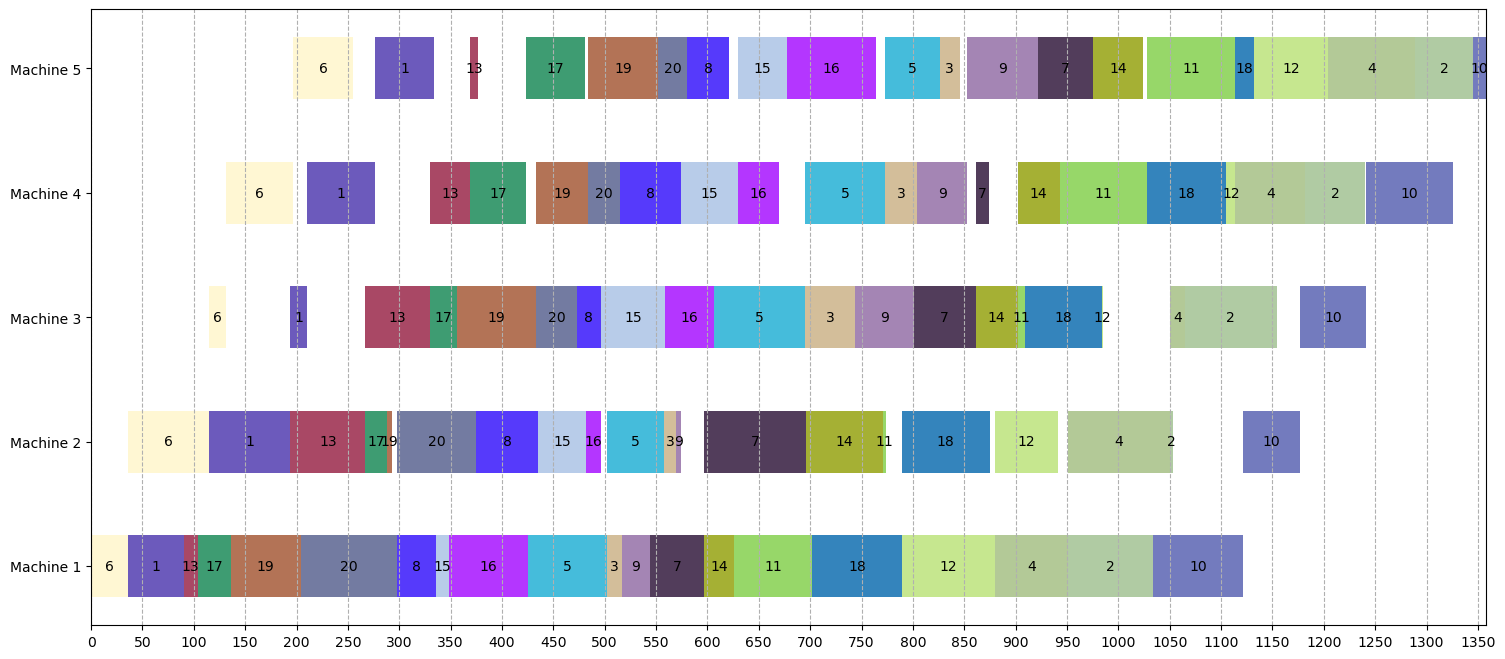

In [17]:
generate_gantt_chart(processing_times,best_solution)

###  Taillard, 50 jobs & 10 machines

In [18]:
nb_jobs = 50
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux

In [19]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100

In [20]:
processing_times = benchmarks[1][2].T # La deuxième instance 

initial_pop =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial Poplation : ", initial_pop)

start_time = time.time()
best_solution  = genetic_algorithm(processing_times, initial_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

Elapsed_time = time.time() - start_time

best_cost =  calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 2892") 
print("Elapsed time:", Elapsed_time, "seconds \n")

RDP = best_cost - 2892
GA_SPO.append(["50 J & 10M",RDP])

Initial Poplation :  [[12, 9, 5, 8, 40, 32, 35, 41, 39, 6, 33, 34, 1, 48, 17, 23, 7, 37, 31, 16, 44, 49, 22, 26, 4, 15, 25, 38, 18, 3, 30, 42, 28, 21, 43, 27, 46, 0, 14, 2, 20, 36, 24, 45, 11, 19, 13, 29, 47, 10], [10, 32, 42, 17, 41, 29, 44, 0, 39, 34, 11, 37, 25, 19, 43, 13, 31, 6, 49, 22, 2, 28, 12, 15, 3, 48, 26, 8, 14, 9, 20, 23, 5, 46, 27, 33, 47, 21, 45, 7, 35, 30, 18, 1, 36, 16, 4, 38, 24, 40], [26, 3, 18, 23, 32, 37, 38, 34, 1, 2, 19, 10, 8, 20, 49, 47, 7, 5, 4, 22, 29, 48, 31, 11, 21, 14, 6, 0, 15, 44, 41, 28, 40, 36, 43, 42, 27, 9, 24, 13, 33, 39, 12, 46, 45, 35, 25, 17, 16, 30], [32, 45, 0, 14, 35, 17, 34, 48, 9, 42, 10, 15, 3, 8, 12, 29, 49, 21, 43, 11, 41, 44, 13, 28, 19, 40, 30, 18, 23, 1, 24, 7, 25, 47, 22, 39, 36, 38, 31, 46, 20, 5, 4, 27, 2, 37, 26, 6, 33, 16], [17, 14, 8, 7, 49, 38, 24, 48, 32, 43, 31, 29, 0, 15, 22, 12, 46, 20, 10, 39, 45, 40, 6, 28, 3, 18, 19, 21, 44, 4, 35, 13, 5, 37, 42, 23, 27, 2, 25, 26, 33, 30, 41, 9, 47, 11, 36, 1, 16, 34], [26, 2, 6, 40, 43,

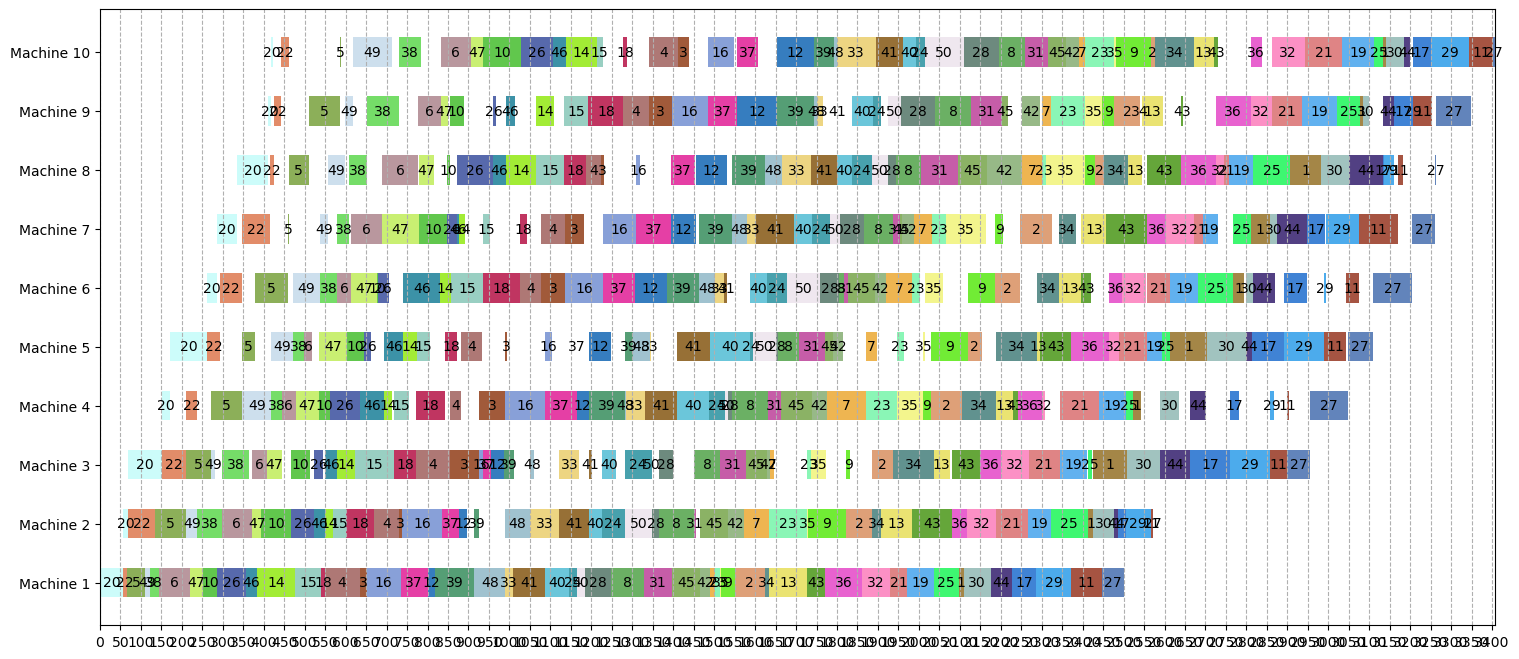

In [21]:
generate_gantt_chart(processing_times,best_solution)

#### Avec les Meilleurs Hyper Parameters

In [22]:
initial_pop , best_pop_size, best_select_pop_size , best_mutation_probability, best_num_iterations = optimal_params_AG(processing_times,"roulette","TWO")

Meilleurs paramètres: pop_size=30, select_pop_size=0.7, mutation_probability=0.09879578424558447, num_iterations=151


In [23]:
print("Initial Poplation : ", initial_pop)

start_time = time.time()

best_solution = genetic_algorithm(processing_times, initial_pop, best_pop_size, best_select_pop_size, selection_method, crossover, best_mutation_probability, best_num_iterations)

Elapsed_time = time.time() - start_time

best_cost= calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution " , best_cost) 
print("Real Makespann is 2892") 
print("Elapsed time:", Elapsed_time, "seconds \n")

RDP = best_cost - 2892
GA_APO.append(["50J & 10M",RDP])


Initial Poplation :  [[32, 22, 42, 4, 48, 3, 33, 8, 15, 11, 44, 45, 10, 20, 40, 25, 46, 27, 43, 21, 9, 18, 17, 14, 26, 41, 35, 36, 2, 7, 34, 5, 49, 29, 30, 0, 39, 19, 12, 31, 37, 24, 38, 6, 28, 1, 16, 47, 13, 23], [38, 20, 37, 3, 16, 39, 12, 7, 15, 18, 17, 33, 27, 43, 21, 36, 24, 30, 8, 5, 0, 34, 22, 32, 49, 42, 48, 19, 4, 25, 1, 23, 35, 46, 45, 40, 44, 9, 47, 2, 14, 31, 10, 11, 13, 26, 28, 6, 41, 29], [32, 11, 3, 39, 9, 33, 29, 38, 14, 46, 45, 15, 8, 23, 30, 36, 25, 24, 47, 0, 40, 5, 34, 43, 2, 27, 4, 49, 21, 44, 7, 37, 17, 6, 35, 28, 19, 42, 22, 10, 13, 20, 31, 41, 16, 18, 1, 12, 48, 26], [0, 21, 18, 31, 8, 41, 25, 2, 20, 42, 22, 38, 4, 3, 13, 37, 30, 35, 47, 27, 40, 19, 12, 28, 14, 39, 48, 7, 45, 34, 29, 46, 43, 11, 44, 26, 24, 6, 36, 9, 5, 10, 49, 33, 1, 16, 23, 15, 32, 17], [30, 14, 28, 49, 27, 4, 43, 41, 0, 11, 16, 6, 13, 23, 29, 2, 21, 25, 24, 8, 1, 31, 5, 44, 9, 47, 32, 37, 42, 33, 7, 40, 39, 18, 19, 12, 26, 15, 48, 17, 35, 36, 38, 34, 45, 20, 10, 46, 3, 22], [26, 15, 11, 12, 2

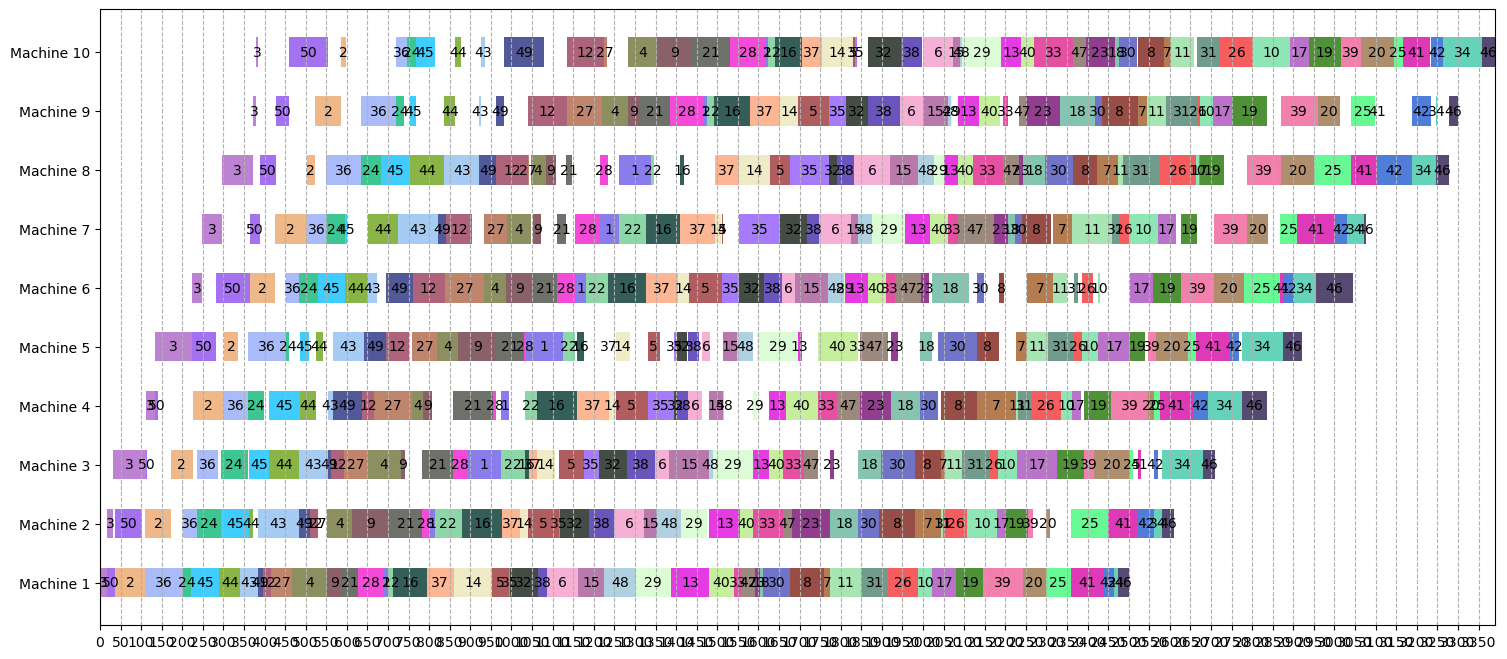

In [24]:
generate_gantt_chart(processing_times,best_solution)

###  Taillard, 100 jobs & 10 machines

In [25]:
nb_jobs = 100
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux

In [26]:
pop_size = 30
select_pop_size = 0.5
selection_method = "roulette"
crossover = "TWO"
mutation_probability = 0.05
num_iterations = 100

In [27]:
processing_times = benchmarks[4][2].T # La 5ème instance 

initial_pop =  [np.random.permutation(processing_times.shape[0]).tolist() for i in range(pop_size)]

print("Initial Poplation : ", initial_pop)

start_time = time.time()
best_solution  = genetic_algorithm(processing_times, initial_pop, pop_size, select_pop_size, selection_method, crossover, mutation_probability, num_iterations)

Elapsed_time = time.time() - start_time

best_cost = calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 5303") 
print("Elapsed time:", Elapsed_time, "seconds \n")

RDP = best_cost - 5303
GA_SPO.append(["100J & 10M",RDP])

Initial Poplation :  [[54, 93, 7, 75, 71, 6, 82, 14, 12, 38, 36, 23, 13, 40, 79, 77, 58, 49, 46, 42, 18, 52, 31, 85, 63, 39, 22, 21, 83, 73, 86, 30, 50, 66, 81, 25, 51, 5, 28, 67, 72, 17, 41, 87, 64, 74, 32, 96, 19, 10, 53, 95, 99, 45, 57, 35, 91, 27, 24, 60, 59, 8, 48, 29, 9, 43, 69, 4, 15, 2, 65, 70, 26, 90, 97, 80, 62, 61, 98, 16, 0, 68, 76, 88, 55, 44, 84, 20, 89, 37, 92, 33, 3, 94, 78, 34, 56, 1, 47, 11], [21, 92, 47, 76, 83, 38, 69, 81, 20, 25, 94, 89, 77, 30, 35, 36, 88, 15, 3, 37, 48, 28, 45, 71, 96, 53, 32, 34, 65, 55, 0, 61, 63, 7, 87, 11, 40, 1, 12, 43, 59, 68, 82, 98, 46, 85, 64, 39, 75, 14, 51, 72, 22, 44, 13, 6, 67, 41, 4, 74, 73, 31, 84, 60, 95, 93, 24, 16, 80, 18, 57, 29, 54, 78, 50, 79, 58, 56, 49, 97, 9, 99, 5, 8, 42, 86, 27, 70, 10, 19, 17, 23, 26, 52, 62, 2, 90, 91, 33, 66], [15, 8, 86, 17, 66, 37, 29, 88, 14, 31, 68, 44, 71, 58, 30, 98, 55, 41, 69, 28, 11, 53, 52, 7, 50, 3, 72, 47, 0, 82, 91, 38, 63, 9, 27, 25, 19, 77, 57, 42, 92, 26, 35, 22, 34, 45, 39, 36, 64, 83

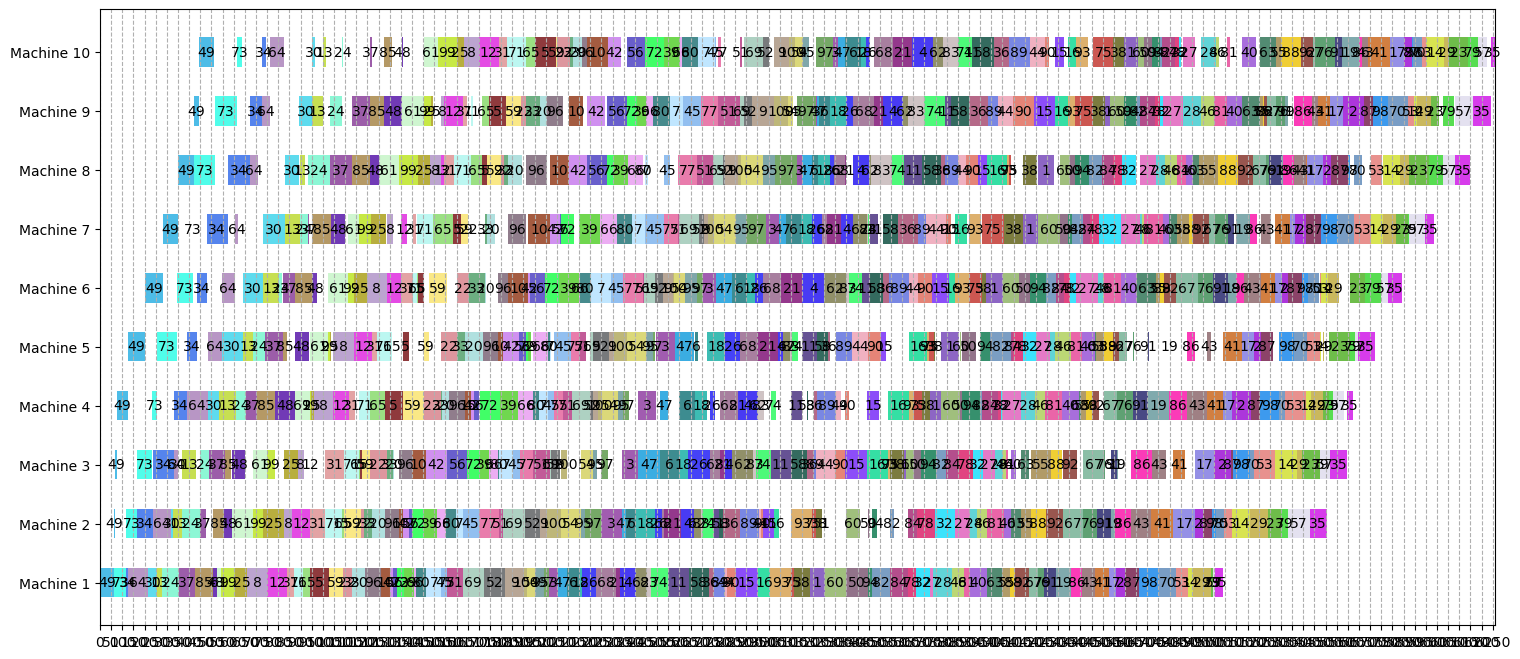

In [28]:
generate_gantt_chart(processing_times,best_solution)

#### Avec les Meilleurs Hyper Parameters

In [29]:
initial_pop , best_pop_size, best_select_pop_size , best_mutation_probability, best_num_iterations = optimal_params_AG(processing_times,"roulette","TWO")

Meilleurs paramètres: pop_size=37, select_pop_size=0.6636172508005995, mutation_probability=0.0728445456804033, num_iterations=152


In [30]:
print("Initial Poplation : ", initial_pop)

start_time = time.time()

best_solution = genetic_algorithm(processing_times, initial_pop, best_pop_size, best_select_pop_size, selection_method, crossover, best_mutation_probability, best_num_iterations)

Elapsed_time = time.time() - start_time

best_cost = calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution " , best_cost) 
print("Real Makespann of Solution 5303") 
print("Elapsed time:", Elapsed_time, "seconds \n")

RDP = best_cost - 5303
GA_APO.append(["100J & 10M",RDP])

Initial Poplation :  [[19, 61, 8, 47, 24, 79, 29, 50, 83, 51, 3, 14, 57, 48, 53, 42, 18, 31, 28, 76, 63, 74, 84, 26, 36, 52, 73, 67, 35, 90, 30, 89, 68, 25, 54, 41, 65, 71, 13, 55, 16, 38, 4, 60, 95, 82, 33, 98, 23, 88, 64, 34, 72, 81, 46, 9, 6, 70, 49, 1, 56, 15, 86, 7, 93, 12, 96, 85, 66, 11, 27, 58, 87, 5, 77, 21, 59, 2, 94, 43, 45, 20, 62, 39, 22, 40, 91, 32, 99, 80, 17, 97, 37, 10, 44, 78, 92, 0, 75, 69], [35, 56, 43, 77, 68, 80, 96, 30, 49, 8, 99, 33, 57, 22, 69, 62, 37, 1, 81, 65, 79, 46, 25, 86, 53, 64, 58, 7, 11, 98, 63, 44, 27, 52, 54, 93, 84, 83, 50, 59, 92, 5, 3, 87, 17, 18, 95, 76, 32, 38, 28, 19, 21, 15, 48, 12, 41, 34, 45, 82, 73, 0, 2, 88, 89, 61, 10, 13, 39, 66, 97, 67, 20, 51, 94, 6, 14, 29, 55, 23, 9, 60, 42, 70, 72, 74, 90, 75, 26, 24, 16, 47, 85, 71, 40, 91, 78, 36, 4, 31], [78, 14, 23, 15, 28, 48, 90, 6, 97, 81, 21, 75, 89, 29, 54, 47, 40, 8, 95, 0, 34, 93, 56, 64, 10, 98, 74, 35, 84, 85, 19, 11, 62, 41, 67, 18, 99, 94, 91, 80, 44, 32, 4, 71, 22, 63, 25, 24, 1, 76

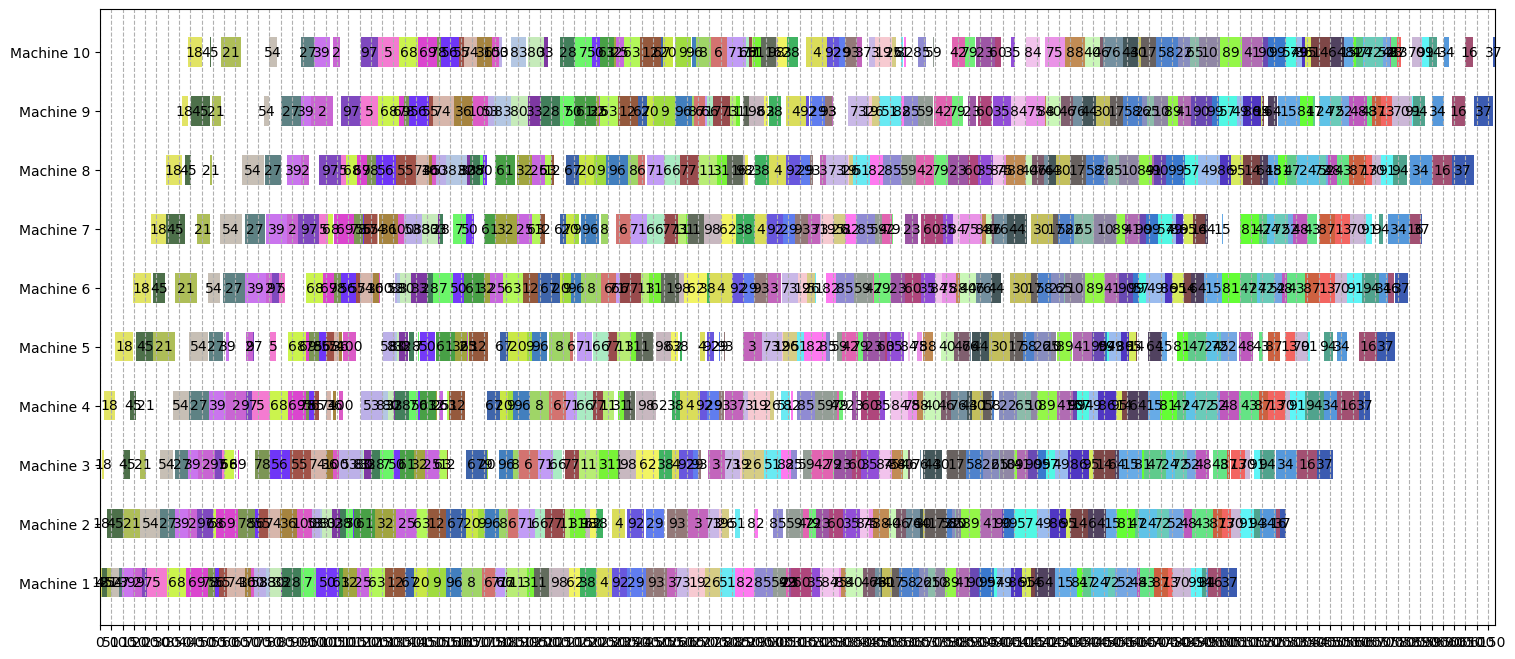

In [31]:
generate_gantt_chart(processing_times,best_solution)

# Ant colony for FSP

In [32]:
class AntColonyOptimization:

    def __init__(self, processingTimes, Alpha=.5, Beta=.5, Q=.9, max_it=10, num_ant=16, rho=0, heuristicSolution =[]) -> None:

        self.numberJobs = processingTimes.shape[0]
        self.numberMachines = processingTimes.shape[1]
        self.Distances = np.zeros((self.numberJobs, self.numberJobs))
        self.processingTimes = processingTimes
        self.archive = heuristicSolution
        self.alpha = Alpha
        self.beta = Beta
        self.Q = Q
        self.globalPheromone = np.ones((self.numberJobs, self.numberJobs))
        self.maxIt = max_it
        self.numAnt = num_ant
        self.rho = rho


    def calculateDistances(self):
        for i in range(self.numberJobs):
            for j in range(self.numberJobs):
                if (i == j):
                    self.Distances[i, j] =0
                else :
                    #self.Distances[i, j] = calculate_makespan(self.processingTimes, [i,j]) - calculate_makespan(self.processingTimes, [i])
                    #self.Distances[i, j] = calculate_makespan(self.processingTimes, [i,j])
                    self.Distances[i, j] = calculate_makespan(self.processingTimes, [j,i])


    # calcule la formule de choix du job à prendre 
    def calculateJobVoisin(self, jobCourant, lePotentielJobVoisin, lesPotentielsJobsVoisins):
        denominateur = 0
        numerateur = 0

        for i in range(len(lesPotentielsJobsVoisins)):
            denominateur += (self.globalPheromone[jobCourant, lesPotentielsJobsVoisins[i]])**self.alpha * (1/self.Distances[jobCourant, lesPotentielsJobsVoisins[i]])**self.beta
        numerateur =  (self.globalPheromone[jobCourant, lePotentielJobVoisin])**self.alpha * (1/self.Distances[jobCourant, lePotentielJobVoisin])**self.beta

        return numerateur/denominateur


    def updateLocalPheromone(self, solutionSequence, localPheromoneMatrix):

        solutionQuality = calculate_makespan(self.processingTimes, solutionSequence)

        for j in range(len(solutionSequence)-1):

            localPheromoneMatrix[solutionSequence[j], solutionSequence[j+1]] += self.Q /solutionQuality
   

    def updateGlobalPheromone(self, localPheromoneMatrix):

        self.globalPheromone = (1-self.rho)*self.globalPheromone + localPheromoneMatrix          
    

    def run(self):

        start_time = time.time()

        self.calculateDistances()

        for it in range(self.maxIt):

            #liste de liste pour contenir les solutions de chaque fourmi

            solutions = []

            localPheromone = np.zeros((self.numberJobs, self.numberJobs))


            for ant in range(self.numAnt): 

                solutions.append([])

                num_job_pris = 0

                #initialisation de la liste contenant les jobs qui constitueront la solution, elle sera updaté à chaque fois qu'un job est pris

                job_dispo = list(range(self.numberJobs))

                # démarrer par un job aléatoirement

                solutions[ant].append(job_dispo[random.randint(0, len(job_dispo) - 1)])
                

                #updating ce qu'il faut

                job_dispo.remove(solutions[ant][num_job_pris])

                num_job_pris +=1

                while(len(job_dispo)>0): # équivaut à dire num_job_pris < self.numberJobs

                    bestVoisin = 0

                    nextJob = None

                    for i in range(len(job_dispo)):

                        #solutions[ant][num_job_pris-1] is the current node

                        voisinActuel = self.calculateJobVoisin(solutions[ant][num_job_pris-1], job_dispo[i], job_dispo)

                        if( voisinActuel > bestVoisin):

                            bestVoisin = voisinActuel

                            nextJob = job_dispo[i]


                    solutions[ant].append(nextJob)

                    #updating ce qu'il faut

                    job_dispo.remove(nextJob)

                    num_job_pris +=1

                #Mise à jour local de phéromone

                self.updateLocalPheromone(solutions[ant], localPheromone) 

                # print("Ant : ", ant, "'s solution : ", solutions[ant]) 

                # print("Its makespan is : ", calculate_makespan(self.processingTimes, solutions[ant]))

            #Mise à jour globale de phéromone 

            self.updateGlobalPheromone(localPheromone)

            # L'idée que j'ai est de calculer le makespan de toutes les solutions et si une est meilleure de celle contenu dans l'archive l'archiver à son tour 

            for sol in range(len(solutions)):

                makespan = calculate_makespan(self.processingTimes, solutions[sol])

                if (makespan < calculate_makespan(self.processingTimes, self.archive)):

                    self.archive = solutions[sol]
                
        print("Elapsed time:", time.time()-start_time, "seconds")

        #Retourner la meilleure solution 

        return self.archive  


In [33]:
algorithms = {
    "NEH":  neh_algorithm,
    "Ham":  ham_heuristic,
    "CDS":  cds_heuristic,
    "Gupta": gupta_heuristic,
    "Palmer":  run_palmer,
    "PRSKE":  PRSKE,
    "Weighted CDS": special_heuristic,
    "NRH": NRH,
    "Chen": chen_heuristic
    }


In [34]:
def generate_heuristic_solution(processing_times ,name = "NEH" ):
    return algorithms[name](processing_times)[0]

## Tests ACO

In [35]:
ACO_SPO = []
ACO_APO = []

###  Taillard, 20 jobs & 5 machines

In [36]:
nb_jobs = 20
nb_machines = 5
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux 

In [37]:
processing_times = benchmarks[0][2].T  #La première instance
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan of Initial Solution: ", calculate_makespan(processing_times, initial_solution))

ACO = AntColonyOptimization(processing_times, Alpha=10, Beta=1, Q=1, max_it=1, num_ant=1, rho=0, heuristicSolution=initial_solution)
result = ACO.run()

best_cost = calculate_makespan(processing_times, result)

print("Solution : ",result)
print("Makespann of solution " ,best_cost)
print("Real Makespann is 1278") 

RDP = best_cost - 1278
ACO_SPO.append(["20J & 5M",RDP])

Initial solution :  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]
Makespan of Initial Solution:  1593
Elapsed time: 0.04915881156921387 seconds
Solution :  [9, 14, 2, 16, 8, 7, 13, 12, 10, 11, 15, 18, 0, 1, 5, 6, 3, 19, 4, 17]
Makespann of solution  1405
Real Makespann is 1278


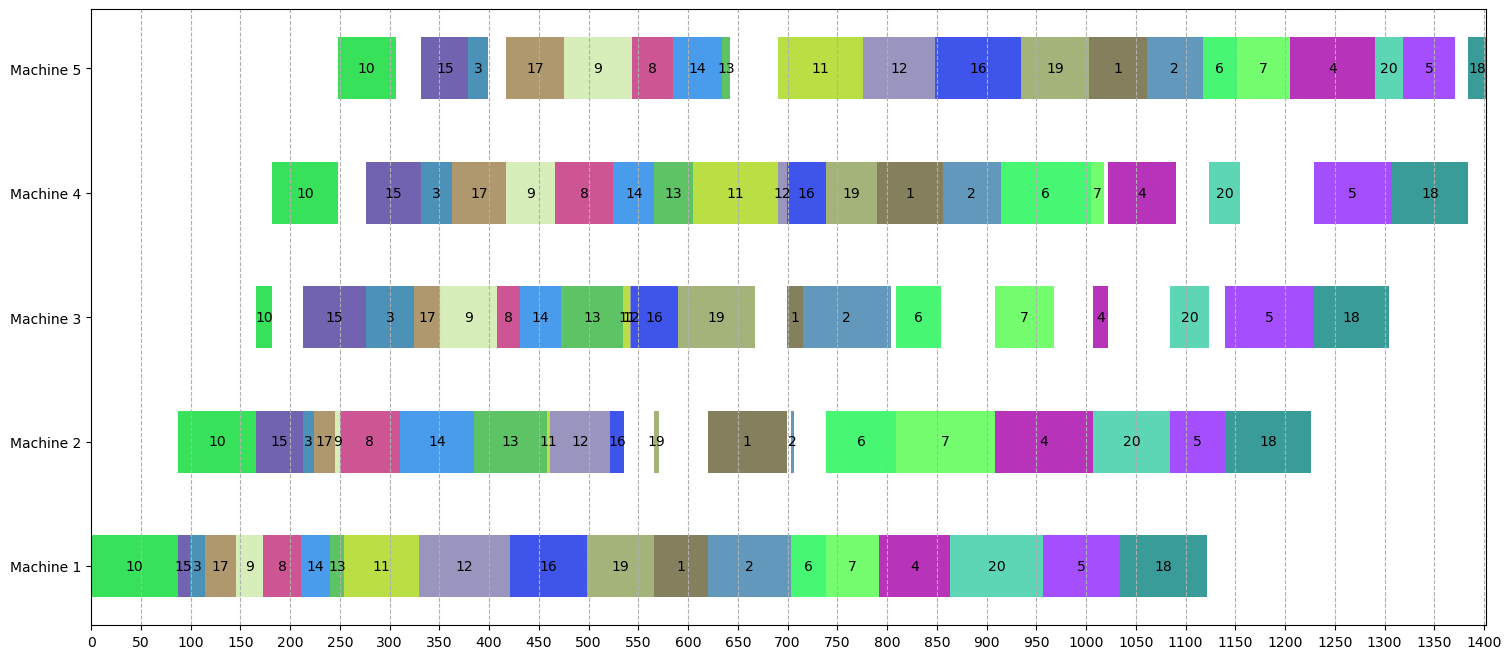

In [38]:
generate_gantt_chart(processing_times,result)

#### Avec Meilleurs Hyper Parameters

In [39]:
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan of Initial Solution: ", calculate_makespan(processing_times, initial_solution))
# Définir l'espace des paramètres
space = [
    Real(0.4, 0.9, name='alpha'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 200, name='it_max'),
    Integer(10, 200, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser

@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=1-alpha, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    res_makespane = calculate_makespan(processing_times, result)
    print(res_makespane)
    return res_makespane


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_Q = result.x[1]
best_it_max = result.x[2]
best_num_ant = result.x[3]
best_rho = result.x[4]


Initial solution :  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]
Makespan of Initial Solution:  1593
Elapsed time: 1560.3606686592102 seconds
1377
Elapsed time: 5.107645750045776 seconds
1324
Elapsed time: 57.01427102088928 seconds
1377
Elapsed time: 26.03703737258911 seconds
1358
Elapsed time: 55.20451736450195 seconds
1377
Elapsed time: 997.2812368869781 seconds
1324
Elapsed time: 11.564460277557373 seconds
1324
Elapsed time: 59.77259039878845 seconds
1324
Elapsed time: 20.750930070877075 seconds
1377
Elapsed time: 81.59538125991821 seconds
1324
Elapsed time: 8.23797607421875 seconds
1324
Elapsed time: 10.41072392463684 seconds
1324
Elapsed time: 8.940101146697998 seconds
1324


KeyboardInterrupt: 

In [ ]:
ACO = AntColonyOptimization(

    processing_times, Alpha=best_alpha, Beta=1-best_alpha, Q=best_Q, max_it=best_it_max, num_ant=best_num_ant, rho=best_rho, heuristicSolution=initial_solution)

result = ACO.run()

best_cost =  calculate_makespan(processing_times, result)

print("Solution : ", result)
print("Makespann of solution", best_cost)
print("Real Makespann is 1278") 

RDP = best_cost - 1278
ACO_APO.append(["20J & 5M",RDP])

Elapsed time: 7.593257188796997 seconds
Solution :  [3, 14, 2, 16, 8, 7, 13, 12, 15, 10, 11, 18, 0, 1, 5, 6, 9, 4, 17, 19]
Makespann of solution 1324
Real Makespann is 1278


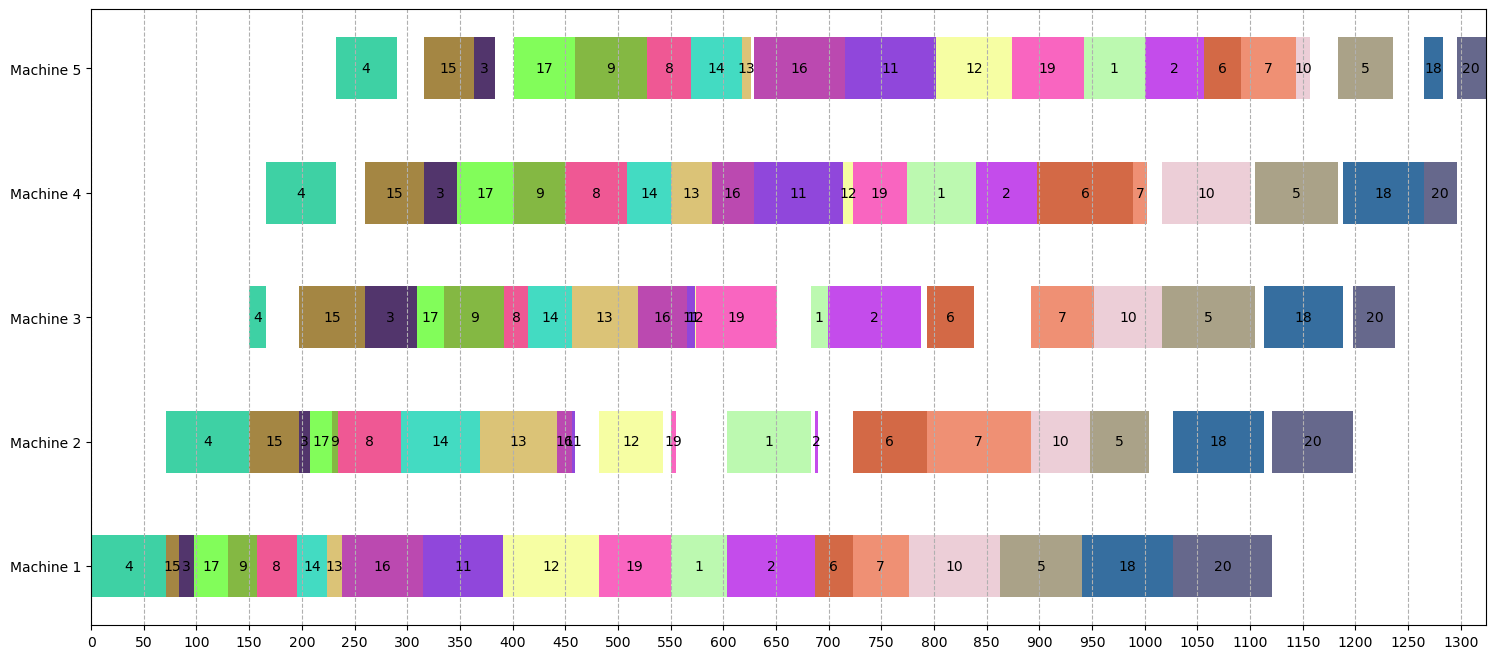

In [ ]:
generate_gantt_chart(processing_times,result)

###  Taillard, 50 jobs & 10 machines

In [ ]:
nb_jobs = 50
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux 

In [ ]:
processing_times = benchmarks[1][2].T  # La deuxième instance 
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan of Initial Solution: ", calculate_makespan(processing_times, initial_solution))

ACO = AntColonyOptimization(processing_times, Alpha=10, Beta=1, Q=1, max_it=1, num_ant=1, rho=0, heuristicSolution=initial_solution)
result = ACO.run()

best_cost = calculate_makespan(processing_times, result)

print("Solution : ",result)
print("Makespann of solution" , best_cost)
print("Real Makespann is 2892") 

RDP = best_cost - 2892
ACO_SPO.append(["50J & 10M",RDP])

Initial solution :  [15, 28, 38, 33, 42, 40, 20, 7, 26, 35, 19, 11, 24, 36, 8, 5, 17, 4, 29, 30, 14, 18, 25, 31, 3, 34, 1, 22, 16, 49, 12, 44, 39, 10, 32, 13, 0, 27, 43, 9, 48, 6, 46, 37, 2, 45, 21, 47, 41, 23]
Makespan of Initial Solution:  3638
Elapsed time: 0.26233386993408203 seconds
Solution :  [30, 41, 27, 32, 2, 48, 34, 49, 10, 23, 21, 0, 45, 9, 22, 13, 47, 6, 43, 37, 25, 8, 46, 17, 11, 24, 36, 5, 31, 16, 39, 26, 19, 38, 14, 44, 4, 29, 1, 33, 40, 12, 28, 42, 3, 18, 15, 35, 20, 7]
Makespann of solution 3591
Real Makespann is 2892


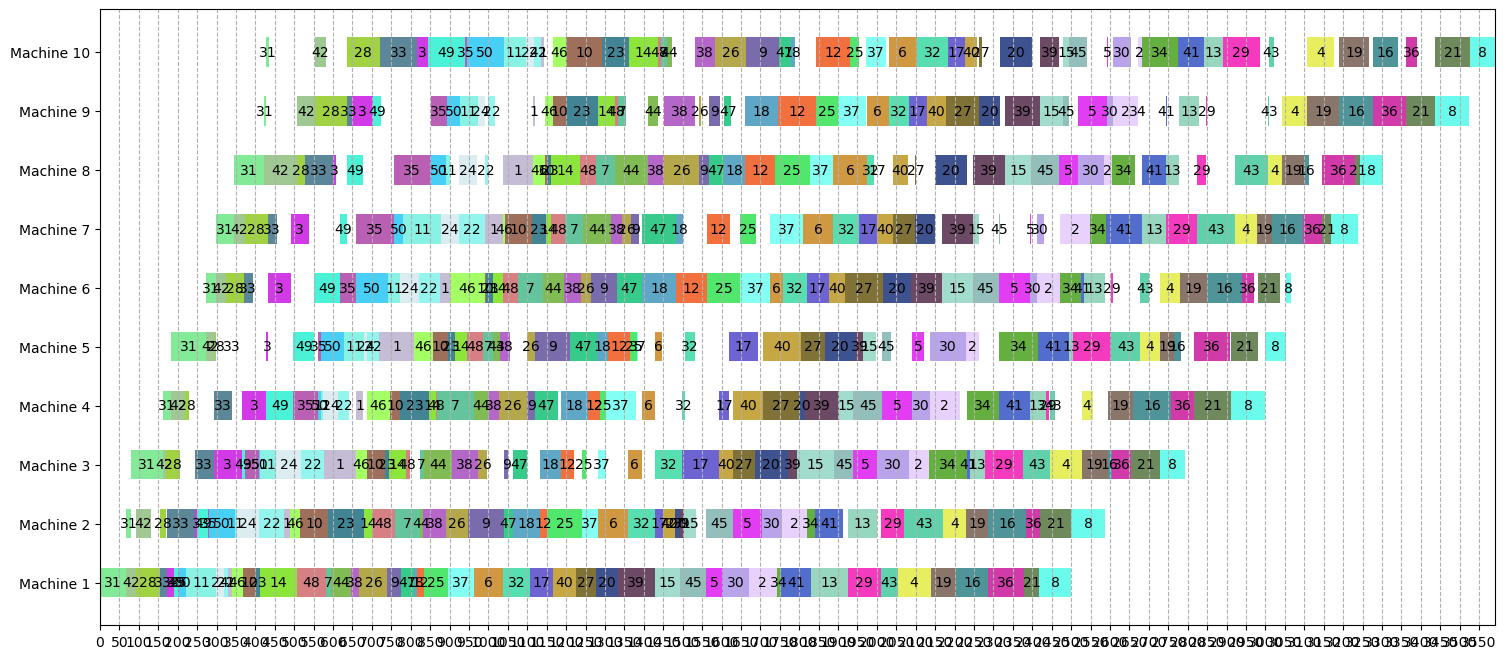

In [ ]:
generate_gantt_chart(processing_times,result)

#### Avec Meilleurs Hyper Parameters

In [ ]:
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan of Initial solution: ", calculate_makespan(processing_times, initial_solution))
# Définir l'espace des paramètres
space = [
    Real(0.4, 0.9, name='alpha'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 200, name='it_max'),
    Integer(10, 200, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser

@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=1-alpha, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    res_makespane = calculate_makespan(processing_times, result)
    print(res_makespane)
    return res_makespane


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_Q = result.x[1]
best_it_max = result.x[2]
best_num_ant = result.x[3]
best_rho = result.x[4]


Initial solution :  [15, 28, 38, 33, 42, 40, 20, 7, 26, 35, 19, 11, 24, 36, 8, 5, 17, 4, 29, 30, 14, 18, 25, 31, 3, 34, 1, 22, 16, 49, 12, 44, 39, 10, 32, 13, 0, 27, 43, 9, 48, 6, 46, 37, 2, 45, 21, 47, 41, 23]
Makespan of Initial solution:  3638


KeyboardInterrupt: 

In [ ]:
ACO = AntColonyOptimization(

    processing_times, Alpha=best_alpha, Beta=1-best_alpha, Q=best_Q, max_it=best_it_max, num_ant=best_num_ant, rho=best_rho, heuristicSolution=initial_solution)

result = ACO.run()

best_cost = calculate_makespan(processing_times, result)

print("Solution : ", result)
print("Makespann of solution ", best_cost)
print("Real Makespann is 2892") 

RDP = best_cost - 2892
ACO_APO.append(["50J & 10M",RDP])

In [ ]:
generate_gantt_chart(processing_times,result)

###  Taillard, 100 jobs & 10 machines

In [ ]:
nb_jobs = 100
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

#### Sans les paramètres optimaux 

In [ ]:
processing_times = benchmarks[4][2].T
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan of Initial solution: ", calculate_makespan(processing_times, initial_solution))

ACO = AntColonyOptimization(processing_times, Alpha=10, Beta=1, Q=1, max_it=1, num_ant=1, rho=0, heuristicSolution=initial_solution)
result = ACO.run()

best_cost =  calculate_makespan(processing_times, result)

print("Solution : ",result)
print("Makespann of Solution " ,best_cost)
print("Real Makespann is 5303") 

RDP = best_cost - 5303
ACO_SPO.append(["100J & 10M",RDP])

In [ ]:
generate_gantt_chart(processing_times,result)

#### Avec Meilleurs Hyper Parameters

In [ ]:
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan Initial solution: ", calculate_makespan(processing_times, initial_solution))
# Définir l'espace des paramètres
space = [
    Real(0.4, 0.9, name='alpha'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 200, name='it_max'),
    Integer(10, 200, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser


@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=1-alpha, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    res_makespane = calculate_makespan(processing_times, result)
    print(res_makespane)
    return res_makespane


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_Q = result.x[1]
best_it_max = result.x[2]
best_num_ant = result.x[3]
best_rho = result.x[4]


In [ ]:
ACO = AntColonyOptimization(

    processing_times, Alpha=best_alpha, Beta=1-best_alpha, Q=best_Q, max_it=best_it_max, num_ant=best_num_ant, rho=best_rho, heuristicSolution=initial_solution)

result = ACO.run()

best_cost = calculate_makespan(processing_times, result)

print("Solution : ", result)
print("Makespann of Solution ", best_cost)
print("Reel Makespann is 5303") 

RDP = best_cost - 5303
ACO_APO.append(["100J & 10M",RDP])

In [ ]:
generate_gantt_chart(processing_times,result)

# Artificial Bee Colony for FSP

In [ ]:
class ArtificialBeeColony:
    def __init__(self, ProcessingTimes, MaxIt=200, nPop=100, nOnlooker=None, L=None):
        self.ProcessingTimes = ProcessingTimes
        self.MaxIt = MaxIt
        self.nPop = nPop
        self.nOnlooker = nOnlooker if nOnlooker is not None else nPop
        self.L = L if L is not None else round(0.6 * self.ProcessingTimes.shape[0] * nPop)
    
    def update_solution(self, A, B, psi):
        a_solution, a_cost = A["Solution"], A["Cost"]
        b_solution, b_cost = B["Solution"], B["Cost"]
        intermediate_solution = a_solution.copy()
        BestSol_l = {'Solution': [], "Cost": float('inf')}
        #print('==========================================================================================')
        #print('A: ', a_solution, a_cost)
        #print('B: ', b_solution, b_cost)
        i = 0
        while i < len(b_solution)-2:
            if psi < 0.5:
                i_i_index = intermediate_solution.index(b_solution[i])
                b_i_index = i
            else:
                b_i_index = b_solution.index(i)
                i_i_index = intermediate_solution.index(i)
            if b_i_index != i_i_index:
                intermediate_solution[b_i_index], intermediate_solution[i_i_index] = intermediate_solution[i_i_index], intermediate_solution[b_i_index]
                intermediate_cost = calculate_makespan(self.ProcessingTimes, intermediate_solution)
                if intermediate_cost < BestSol_l["Cost"]:
                    BestSol_l["Solution"] = intermediate_solution.copy()
                    BestSol_l["Cost"] = intermediate_cost
            i+=1
                
        return BestSol_l
    
    def run(self):

        start_time = time.time()
        
        # Initialization
        pop = self.initialize_population()
        print(min(pop, key=lambda x: x['Cost']))
        BestSol = min(pop, key=lambda x: x['Cost'])
        C = np.zeros(self.nPop)
        BestCost = np.zeros(self.MaxIt)
        
        # ABC Main Loop
        for it in range(self.MaxIt):
            # Recruited Bees
            for i in range(self.nPop):
                K = list(range(i)) + list(range(i+1, self.nPop))
                k = np.random.choice(K)
                psi = np.random.uniform(-1, 1)
                if psi < 0:
                    newbee = self.update_solution(pop[k], pop[i], abs(psi))
                else:
                    newbee = self.update_solution(pop[i], pop[k], abs(psi))
                
                if newbee['Cost'] < pop[i]['Cost']:
                    pop[i] = newbee
                else:
                    C[i] += 1
            
            # Calculate Fitness Values and Selection Probabilities
            F = np.exp(-np.array([x['Cost'] for x in pop]) / np.mean([x['Cost'] for x in pop]))
            P = F / np.sum(F)
            
            # Onlooker Bees
            for m in range(self.nOnlooker):
                #i = self.roulette_wheel_selection(P)
                i = np.argmax(P)
                P[i] = -np.inf
                K = list(range(i)) + list(range(i+1, self.nPop))
                k = np.random.choice(K)
                psi = np.random.uniform(-1, 1)
                if psi < 0:
                    newbee = self.update_solution(pop[k], pop[i], abs(psi))
                else:
                    newbee = self.update_solution(pop[i], pop[k], abs(psi))
                    
                if newbee['Cost'] < pop[i]['Cost']:
                    pop[i] = newbee
                else:
                    C[i] += 1
            
            # Scout Bees
            for i in range(self.nPop):
                if C[i] >= self.L:
                    pop[i] = {'Solution': self.initialize_a_solution()}
                    pop[i]['Cost'] = calculate_makespan(self.ProcessingTimes, pop[i]['Solution'])
                    C[i] = 0
            
            # Update Best Solution Ever Found
            BestSol = min(pop + [BestSol], key=lambda x: x['Cost'])
            # Store Best Cost Ever Found
            BestCost[it] = BestSol['Cost']
            
            # Display Iteration Information
            # print(f"Iteration {it + 1}: Best Cost = {BestCost[it]}")
        print("Elapsed time:", time.time()-start_time, "seconds")
        return BestSol['Solution']
    
    def initialize_population(self):
        pop = []
        for _ in range(self.nPop):
            bee = {'Solution': self.initialize_a_solution()}
            bee['Cost'] = calculate_makespan(self.ProcessingTimes, bee['Solution'])
            pop.append(bee)
        return pop
    
    def initialize_a_solution(self):
        def random_solution(processing_times):
            n_jobs = processing_times.shape[0]
            solution = list(range(n_jobs))
            random.shuffle(solution)
            return solution, 0
            
        algorithms = {
            "NEH":  neh_algorithm,
            "Ham":  ham_heuristic,
            "CDS":  cds_heuristic,
            "Gupta": gupta_heuristic,
            "Palmer":  run_palmer,
            "PRSKE":  PRSKE,
            "Weighted CDS": special_heuristic,
            "NRH": NRH,
            "Chen": chen_heuristic,
            "random": random_solution
            }    
        def generate_heuristic_solution(processing_times ,name = "NEH" ):
            return algorithms[name](processing_times)[0]
        
        solution = generate_heuristic_solution(self.ProcessingTimes, name=random.choice(list(algorithms.keys())))
        return list(solution)
    
    def roulette_wheel_selection(self, P):
        r = np.random.rand()
        C = np.cumsum(P)
        for i in range(len(C)):
            if r <= C[i]:
                return i

# Tests ABC

In [ ]:
ABC_SPO = []

###  Taillard, 20 jobs & 5 machines

In [ ]:
nb_jobs = 20
nb_machines = 5
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)
processing_times = benchmarks[0][2].T # la première instance 

In [ ]:
ABC = ArtificialBeeColony(processing_times, MaxIt=200, nPop=100, nOnlooker=40, L=5)
BestSol = ABC.run()

best_cost = calculate_makespan(processing_times, best_solution)
print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 1278") 

RDP = best_cost - 1278
ABC_SPO.append(["20J & 5M",RDP])

{'Solution': [10, 14, 3, 15, 18, 16, 5, 4, 0, 2, 12, 11, 1, 13, 8, 7, 17, 9, 6, 19], 'Cost': 1305}
Elapsed time: 83.85454726219177 seconds


ValueError: too many values to unpack (expected 2)

###  Taillard, 50 jobs & 10 machines

In [ ]:
nb_jobs = 50
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

In [ ]:
ABC = ArtificialBeeColony(processing_times, MaxIt=200, nPop=100, nOnlooker=40, L=5)
BestSol = ABC.run()

best_cost = calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 2892") 

RDP = best_cost - 2892
ABC_SPO.append(["50J & 10M",RDP])

###  Taillard, 100 jobs & 10 machines

In [ ]:
nb_jobs = 100
nb_machines = 10
benchmarks = read_flow_shop_data(f'./utils/benchmarks/{nb_jobs}_{nb_machines}.txt', nb_machines, nb_jobs)

In [ ]:
ABC = ArtificialBeeColony(processing_times, MaxIt=200, nPop=100, nOnlooker=40, L=5)
BestSol, BestCost = ABC.run()

best_cost = calculate_makespan(processing_times, best_solution)

print("Solution : ", best_solution)
print("Makespann of Solution" , best_cost) 
print("Real Makespann is 5303") 

RDP = best_cost - 5303
ABC_SPO.append(["100J & 10M",RDP])

# Comparison Figure

- **Remarque :** Comparaison de tous les algorithme ( sans les paramètres optimaux )

In [ ]:
def histogramme(GA_SPO, ACO_SPO, ABC_SPO, xlabel='Benchmarks', ylabel='RDP', title='RDP par méthode et benchmark'):
    # Extraire les noms des benchmarks et les valeurs RDP pour chaque méthode
    benchmarks = [item[0] for item in GA_SPO]  # Assumant que tous les listes ont les mêmes benchmarks
    GA_values = [item[1] for item in GA_SPO]
    ACO_values = [item[1] for item in ACO_SPO]
    ABC_values = [item[1] for item in ABC_SPO]
    
    # Positions des groupes sur l'axe des X
    x = np.arange(len(benchmarks))

    # Largeur des barres
    width = 0.25

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, GA_values, width, label='GA')
    rects2 = ax.bar(x, ACO_values, width, label='ACO')
    rects3 = ax.bar(x + width, ABC_values, width, label='ABC')

    # Ajout des noms de benchmarks sur l'axe des X et des légendes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks)
    ax.legend()

    # Fonction pour ajouter les valeurs sur les barres
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()

    plt.show()


In [ ]:
# Appel de la fonction
histogramme(GA_SPO, ACO_SPO, ABC_SPO)